In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
maindir = '/Users/yixinglu/Documents/UCD/LAB/encap carrier model/results/digestion/image/deepyeast'
os.chdir(maindir)

In [3]:
# helper functions
def extract_filepaths_and_labels(path):
    import pandas as pd
    ff = pd.read_csv(path)
    filepaths = ff['filename'].tolist()
    y = np.array(ff['label'],dtype='uint8')-1
    return filepaths, y

def load_data(split):
    datadir = '/Users/yixinglu/Documents/UCD/LAB/encap carrier model/results/digestion/image/deepyeast/deepyeast/data/'
    train_path = datadir+'image_label_train.csv'
    val_path = datadir+'image_label_val.csv'
    test_path = datadir+'image_label_test.csv'
    if split == 'train':
        filepaths, y = extract_filepaths_and_labels(train_path)
    elif split == 'val':
        filepaths, y = extract_filepaths_and_labels(val_path)
    elif split == 'test':
        filepaths, y = extract_filepaths_and_labels(test_path)
    filepaths = [os.path.join(datadir, x) for x in filepaths]
    print("Loading images...")    
    num_imgs = len(filepaths)
    x = np.empty((num_imgs, 64, 64, 2), dtype='uint8')
    from PIL import Image
    for i in range(num_imgs):
        img = Image.open(filepaths[i])
        img = np.asarray(img, dtype='uint8')
        x[i] = img[:, :, :2] # R,G channels
    print("Loading completed.")   
    return x, y

In [8]:
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout,Flatten,BatchNormalization, Activation
from tensorflow.keras.models import Model

from deepyeast.utils import preprocess_input
from deepyeast.models import DeepYeast

In [5]:
# load data
x_train, y_train = load_data('train')
x_val, y_val = load_data('val')

Loading images...
Loading completed.
Loading images...
Loading completed.


In [9]:
# convert class vectors to binary class matrices: to use with categorical_crossentropy loss
num_classes = 3
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

# transform input images to [-1, 1]
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

In [19]:
#!pip install keras-tuner -q

In [6]:
import keras_tuner

In [ ]:
# load pre-trained CNN model 
base_model = DeepYeast()
weights_path =maindir+'/deepyeast/weights/deepyeast-weights-22-0.902.hdf5'
base_model.load_weights(weights_path)

# re-train the fully connected block while tuning the number of units in the fully connected layer
def build_model(hp):
    x=base_model.layers[-11].output # flattened after conv2D blocks
    # Tune number of units in the fully connected layer
    x=Dense(units=hp.Int("units", min_value=32, max_value=512, step=2, sampling='log'),name='ip1')(x)
    x=BatchNormalization(name='bn4')(x)
    x=Activation('relu', name='relu4')(x)
    x=Dropout(0.5)(x)
    # classification layer (output layer)
    x=Dense(num_classes, activation='softmax',name='classifier')(x)
    model = Model(inputs=base_model.input,outputs=x)
    
    for layer in model.layers[:26]:
        layer.trainable = False
    
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.experimental.AdamW(learning_rate=0.001),
                  #optimizer=keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True),
                  metrics=['accuracy'])
    return model

# summary of the model architechture
tmp=build_model(keras_tuner.HyperParameters())
tmp.summary()

In [ ]:
# tuner
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    executions_per_trial=2,
    overwrite=True,
    directory="./deepyeast/logs",
    project_name="hp_search2",
)

# callbacks
import datetime
# save training and validation accuracy for each epoch 
tensorboard_callback =keras.callbacks.TensorBoard(log_dir="./deepyeast/logs/hp_search2/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# save model weights every 5 epochs
checkpoint = keras.callbacks.ModelCheckpoint(filepath="./deepyeast/logs/hp_search2",
                                             monitor='val_accuracy',
                                             verbose=0,
                                             save_weights_only=True,
                                             save_freq=5
                                            )
# Reduce learning rate when validation accuracy has stopped improving.
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, cooldown=0, min_lr=1e-5)

# search
tuner.search(x_train, y_train,
             batch_size=64,
             epochs=50,
             validation_data=(x_val, y_val),
             callbacks=[tensorboard_callback,reduce_lr,checkpoint])

In [ ]:
tuner.results_summary() # the model is the best when the fully connected layer has 128 units 

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
# visualize the accuracy vs. epoch number during training
%tensorboard --logdir deepyeast/logs/hp_search2/20230227-024952

In [ ]:
# train the model with augmented data
from keras.preprocessing.image import ImageDataGenerator
# number of transformations = 11*11*2=242
datagen = ImageDataGenerator(width_shift_range=5./64,
                             height_shift_range=5./64,
                             horizontal_flip=True)
batch_size = 64
epochs = 50
steps_per_epoch = int(np.ceil(x_train.shape[0]/ float(batch_size)))
# callbacks
tensorboard_callback =keras.callbacks.TensorBoard(log_dir="./deepyeast/logs/data_aug/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
checkpoint = keras.callbacks.ModelCheckpoint(filepath="./deepyeast/logs/data_aug/weights.{epoch:02d}.hdf5",
                                             monitor='val_accuracy',
                                             verbose=0,
                                             save_weights_only=True,
                                             save_freq=10
                                            )
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, cooldown=0, min_lr=1e-5)

model = build_model(tuner.get_best_hyperparameters()[0])
model.fit(datagen.flow(x_train, y_train, batch_size=batch_size,shuffle=True),
          steps_per_epoch=steps_per_epoch,
          epochs=epochs,
          validation_data=(x_val, y_val),
          callbacks=[tensorboard_callback,reduce_lr,checkpoint])

In [ ]:
# visualize the trianing process: training the model with data augmentation improved the accuracy
%tensorboard --logdir deepyeast/logs/data_aug/20230227-181814

## Current model architecture

In [10]:
# load pre-trained CNN model 
base_model = DeepYeast()
weights_path =maindir+'/deepyeast/weights/deepyeast-weights-22-0.902.hdf5'
base_model.load_weights(weights_path)

# update the fully connected layer block
x=base_model.layers[-11].output # flattened after conv2D blocks
# fully connected layer
x=Dense(128,name='ip1')(x)
x=BatchNormalization(name='bn4')(x)
x=Activation('relu', name='relu4')(x)
x=Dropout(0.5)(x)
# classification layer (output layer)
x=Dense(num_classes, activation='softmax',name='classifier')(x)
model = Model(inputs=base_model.input,outputs=x)
model.load_weights("./deepyeast/logs/data_aug/weights.40.hdf5")

In [11]:
# t-SNE visualization
import keras.backend as K
# get output activations for the following layers: input layer, 'relu1_2', 'relu2_2', 'relu3_4','ip1',classifier'
def get_output_activation(input_data,layer_name):
    # Define a function to get the output activations of a layer
    get_layer_output = K.function([model.layers[0].input], [model.get_layer(layer_name).output])

    # Get the output activations of a layer for a given input data
    layer_output = get_layer_output([input_data])[0]
    if layer_output.ndim>2:
        layer_output = layer_output.reshape(layer_output.shape[0], -1)
    return layer_output

In [14]:
x_test,y_test=load_data('test')
x_test = preprocess_input(x_test)

hidden_layer_output = []
for layer_name in ['input_1','relu1_2', 'relu2_2', 'relu3_4','ip1','classifier']:
    hidden_layer_output.append(get_output_activation(x_test,layer_name))

Loading images...
Loading completed.


In [20]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne_output=[]
# Apply t-SNE to the output activations
for i in range(6):
    tsne_output.append(TSNE(n_components=2).fit_transform(hidden_layer_output[i]))

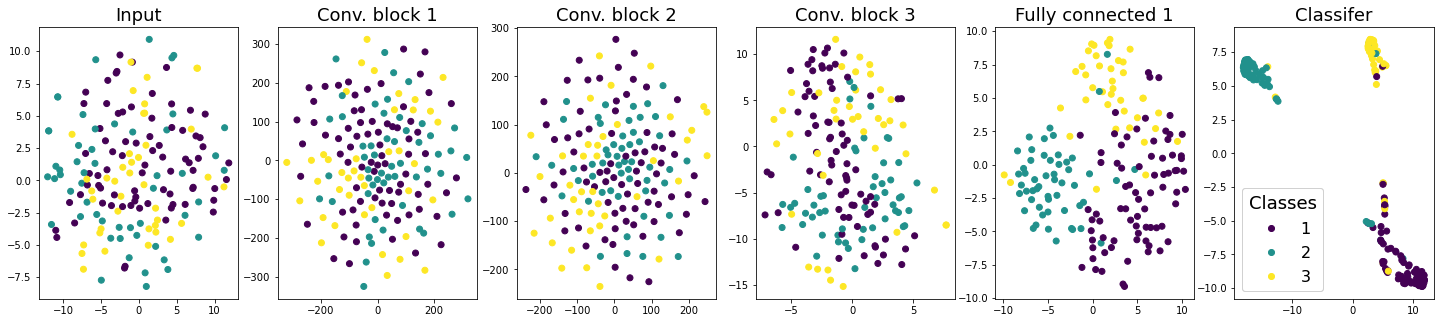

In [30]:
# Visualize the t-SNE plot
subplots_title=['Input','Conv. block 1','Conv. block 2','Conv. block 3','Fully connected 1','Classifer']
fig, ax = plt.subplots(1, 6, figsize=(25,5))
for i in range(6):
    p=ax[i].scatter(tsne_output[i][:, 0], tsne_output[i][:, 1],c=y_test+1)
    ax[i].set_title(subplots_title[i],{'fontsize':18})
    if i==5:
        legend = ax[i].legend(*p.legend_elements(),
                        loc="lower left", title="Classes",fontsize=16,title_fontsize=18)
        ax[i].add_artist(legend)
plt.savefig('./deepyeast/logs/data_aug/20230227-181814/tsne.png')

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 2)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 64, 64, 64)        1216      
                                                                 
 bn1_1 (BatchNormalization)  (None, 64, 64, 64)        256       
                                                                 
 relu1_1 (Activation)        (None, 64, 64, 64)        0         
                                                                 
 conv1_2 (Conv2D)            (None, 64, 64, 64)        36928     
                                                                 
 bn1_2 (BatchNormalization)  (None, 64, 64, 64)        256       
                                                                 
 relu1_2 (Activation)        (None, 64, 64, 64)        0     

In [33]:
yhat_test = model.predict(x_test).argmax(axis=1)

6/6 [==============================] - 3s 258ms/step


In [46]:
mis_2as1=np.where((yhat_test==0)&(y_test==1))
mis_3as1=np.where((yhat_test==0)&(y_test==2))

In [38]:
image_label_test = pd.read_csv('deepyeast/data/image_label_test.csv')

In [47]:
image_label_test.iloc[mis_2as1[0],]

,Unnamed: 0,filename,label
16,865,ret_09448/ret_09448_360.tif,2
90,758,ret_09448/ret_09448_253.tif,2
105,548,ret_09448/ret_09448_43.tif,2
113,823,ret_09448/ret_09448_318.tif,2
141,565,ret_09448/ret_09448_60.tif,2
